# Preparation

In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
results = pd.DataFrame()

# Load C14 models

In [3]:
import c14_models

# Read patient data

In [11]:
c14_patient_data = pd.read_pickle('./data/C14data_liver_samples_20180505.pkl')

In [12]:
c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,pathology,subject_age,valid
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,N,73.583333,True
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,N,25.416667,True
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,N,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,N,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,N,58.333333,True


In [13]:
exp_data = c14_patient_data.query('valid and type == "hepatocyte" and pathology == "N"').copy()
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,pathology,subject_age,valid
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,N,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,N,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,N,58.333333,True
5,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,N,59.000000,True
7,hepatocyte,PH10,ND388,1991.416667,2016.833333,0.018573,N,25.416667,True


In [14]:
exp_data.describe()

,Dbirth,Dcoll,d14C,subject_age
count,19.000000,19.000000,19.000000,19.000000
mean,1967.671053,2015.785088,0.043154,48.114035
std,21.361517,3.878987,0.020627,20.389271
min,1932.583333,2004.833333,0.018573,20.000000
25%,1947.333333,2016.500000,0.030750,32.416667
50%,1971.083333,2017.166667,0.039131,46.083333
75%,1984.541667,2017.416667,0.050080,65.208333
max,1997.333333,2017.500000,0.090351,84.583333


# SSE & log-likelihood

In [15]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [16]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [17]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [18]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return c14_models.I1c(Dbirth, Dcoll, lam)

## Fit

In [19]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, exp_data),
                  Ns = 50,
                  full_output = True,
                  finish=None)

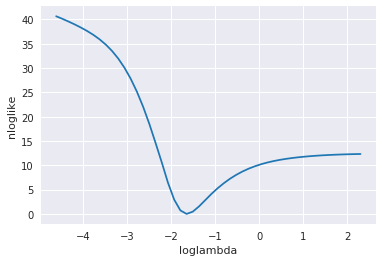

In [20]:
plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

In [21]:
res_I1 = sp.optimize.minimize(fun=Nloglike, 
                     x0=[-1.0],
                     args = (I1, exp_data),
                    )

In [22]:
res_I1

      fun: -51.52572748721414
 hess_inv: array([[0.01678922]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 6
     njev: 9
   status: 0
  success: True
        x: array([-1.64078924])

## Result

In [23]:
print('lamda', sp.exp(res_I1.x[0]))

print('sigma', Sigma(res_I1.x, I1, exp_data))

results.loc['I1', 'loglike'] = -res_I1.fun
results.loc['I1', 'k'] = 2
results.loc['I1', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.1938270067736223
sigma 0.016069713506017554


,loglike,k,n,cAIC
I1,51.525727,2.0,19.0,-98.301455


# I1 Memory

In [24]:
@np.vectorize
def I1_memory(Dbirth, Dcoll, loglam, f, t0):
    lam = np.exp(loglam)
    C1 = c14_models.I1c(Dbirth, Dcoll, lam)
    
    if t0>Dcoll-Dbirth:
        return C1
    else:
        C0 = c14_models.I1c(Dbirth, Dbirth + t0, lam)
        return f*C1 + (1-f)*C0

## Fit

In [40]:
res_I1_memory = sp.optimize.minimize(fun=Nloglike, 
                     x0=[np.log(0.5), 0.7, 30.0],
                     args = (I1_memory, exp_data),
                                     method='Nelder-Mead'
                    )

## Result

In [41]:
print('lamda', sp.exp(res_I1_memory.x[0]))
print('f', res_I1_memory.x[1])
print('t0', res_I1_memory.x[2])

print('sigma', Sigma(res_I1_memory.x, I1_memory, exp_data))

results.loc['I1_memory', 'loglike'] = -res_I1_memory.fun
results.loc['I1_memory', 'k'] = 4
results.loc['I1_memory', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.261375751884222
f 0.9582444833693944
t0 31.30801990873222
sigma 0.014535432540393387


,loglike,k,n,cAIC
I1,51.525727,2.0,19.0,-98.301455
I1_memory,53.432322,4.0,19.0,-96.007500


## Plot

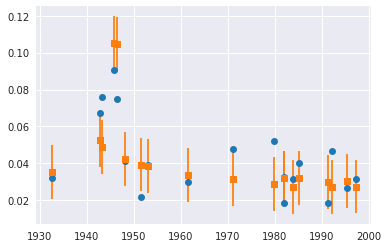

In [42]:
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls='None', marker='o')

plt.errorbar(exp_data['Dbirth'], 
             I1_memory(exp_data['Dbirth'], 
                      exp_data['Dcoll'],
                      *res_I1_memory.x),
             Sigma(res_I1_memory.x, I1_memory, exp_data),
             ls = 'None', marker='s')

plt.show()

# I1T_step

In [43]:
I1T = c14_models.I1T

In [44]:
@np.vectorize
def I1T_step(Dbirth, Dcoll, loglam1, loglam2, t_step):
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    
    def lam_step(t, lam1, lam2, t_step):
        return np.where(t < Dbirth + t_step, lam1, lam2)
    
    return I1T(Dbirth, Dcoll, lam_step, t_eval=np.linspace(Dbirth, Dcoll), lam_arg=(lam1, lam2, t_step))[1][-1]

## Fit

In [45]:
res_I1T_step = sp.optimize.minimize(fun=Nloglike, 
                           x0=[-2, -1, 30.0],
                           args = (I1T_step, exp_data),
                           method="Nelder-Mead"
                          )

## Result

In [46]:
print('lamda1', np.exp(res_I1T_step.x[0]))
print('lamda2', np.exp(res_I1T_step.x[1]))
print('t_step', res_I1T_step.x[2])

print('sigma', Sigma(res_I1T_step.x, I1T_step, exp_data))

results.loc['I1T_step', 'loglike'] = -res_I1T_step.fun
results.loc['I1T_step', 'k'] = 4
results.loc['I1T_step', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda1 0.2286040930231363
lamda2 0.1786314036549249
t_step 34.416619169894986
sigma 0.015764500669119916


,loglike,k,n,cAIC
I1,51.525727,2.0,19.0,-98.301455
I1_memory,53.432322,4.0,19.0,-96.007500
I1T_step,51.890066,4.0,19.0,-92.922990


# I1T_transient

In [47]:
@np.vectorize
def I1T_transient(Dbirth, Dcoll, loglam1, loglam2, t_on, t_off):
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    
    def lam_transient(t, lam1, lam2, t_on, t_off):
        return np.where(np.logical_or(t < Dbirth + t_on,
                                      t > Dbirth + t_on + t_off),
                        lam1, 
                        lam2)
    
    return I1T(Dbirth, Dcoll, lam_transient, 
               t_eval=np.linspace(Dbirth, Dcoll), 
               lam_arg=(lam1, lam2, t_on, t_off)
              )[1][-1]

## Fit

In [48]:
res_I1T_transient = sp.optimize.minimize(fun=Nloglike, 
                           x0=[-2.0, -3.0, 60.0, 70],
                           args = (I1T_transient, exp_data),
                           method="Nelder-Mead"
                          )

## Result

In [49]:
print('lamda1', np.exp(res_I1T_transient.x[0]))
print('lamda2', np.exp(res_I1T_transient.x[1]))
print('t_on', res_I1T_transient.x[2])
print('t_off', res_I1T_transient.x[3])

sig = Sigma(res_I1T_transient.x, I1T_transient, exp_data)
print('sigma', sig)

results.loc['I1T_transient', 'loglike'] = -res_I1T_transient.fun
results.loc['I1T_transient', 'k'] = 5
results.loc['I1T_transient', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda1 0.2331777341705594
lamda2 0.11698672222534497
t_on 59.46991773520403
t_off 84.06887014500826
sigma 0.013969642815179052


,loglike,k,n,cAIC
I1,51.525727,2.0,19.0,-98.301455
I1_memory,53.432322,4.0,19.0,-96.007500
I1T_step,51.890066,4.0,19.0,-92.922990
I1T_transient,54.186673,5.0,19.0,-93.757961


# Plot I1, I1T, I1_memory

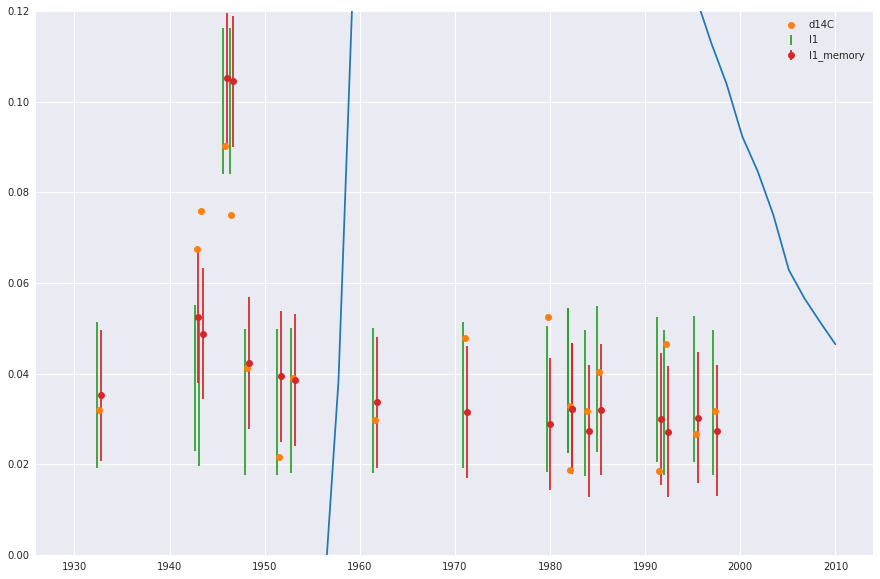

In [51]:
fig, ax = plt.subplots(figsize=(15, 10))
tt = np.linspace(1930, 2010)
ax.plot(tt, np.vectorize(c14_models.C_atm)(tt))
ax.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 'o')

ax.errorbar(exp_data['Dbirth']-0.2, 
            I1(exp_data['Dbirth'].values,
               exp_data['Dcoll'].values,
               *res_I1.x
               ),
           Sigma(res_I1.x, I1, exp_data),
           ls='None',
           label = 'I1')

# ax.errorbar(exp_data['Dbirth'], 
#             I1T_transient(exp_data['Dbirth'].values,
#                           exp_data['Dcoll'].values,
#                           *res_I1T_transient.x
#                          ),
#            Sigma(res_I1T_transient.x, I1T_transient, exp_data),
#            ls='None',
#             marker='s',
#            label = 'I1T_transient')

ax.errorbar(exp_data['Dbirth']+0.2, 
             I1_memory(exp_data['Dbirth'], 
                      exp_data['Dcoll'],
                      *res_I1_memory.x),
             Sigma(res_I1_memory.x, I1_memory, exp_data),
             ls = 'None',
            marker='o',
           label='I1_memory')


ax.set_ylim((0, 0.12))
ax.legend()
plt.show()

# IK

In [200]:
@np.vectorize
def IK(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IK(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [201]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-1.5, 1), (0.2, 0.95)],
                  args = (IK, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-1.23684211  0.59473684]
-189.71039882796586


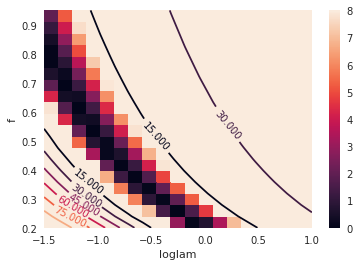

In [202]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [203]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IK, exp_data)
print('sigma', sig)

results.loc['IK', 'loglike'] = -res[1]
results.loc['IK', 'k'] = 3
results.loc['IK', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.2902995072708592
f 0.5947368421052632
sigma 0.021255849868582043


,loglike,k,n,cAIC
I1,189.710960,2.0,78.0,-375.261919
I1T_step,189.739447,4.0,78.0,-370.930949
I1T_transient,191.647034,5.0,78.0,-372.460734
IK,189.710399,3.0,78.0,-373.096473


# IL

In [204]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [ ]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, 2), (0.01, 0.99)],
                  args = (IL, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

In [ ]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [ ]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IL, exp_data)
print('sigma', sig)

results.loc['IL', 'loglike'] = -res[1]
results.loc['IL', 'k'] = 3
results.loc['IL', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# I2

In [ ]:
@np.vectorize
def I2(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.I2(Dbirth, Dcoll, lam, f, 
                         t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [ ]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-3, 0.5), (0.85, 1)],
                  args = (I2, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

In [ ]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

In [ ]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], I2, exp_data)
print('sigma', sig)

results.loc['I2', 'loglike'] = -res[1]
results.loc['I2', 'k'] = 3
results.loc['I2', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# Scenario IX2p

In [ ]:
@np.vectorize
def IX2p(Dbirth, Dcoll, dloglam1, dloglam2, f1):
    dlam1 = np.exp(dloglam1)
    dlam2 = np.exp(dloglam2)
    
    f2 = 1-f1
    
    return c14_models.IX(Dbirth, Dcoll, [dlam1, dlam2], [f1, f2],
                        t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [ ]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(2.0)),(np.log(0.01), np.log(2.0)) , (0, 1)],
                  args = (IX2p, exp_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

## Result

In [ ]:
results.loc['IX2p', 'loglike'] = -res[1]
results.loc['IX2p', 'k'] = 4
results.loc['IX2p', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# Results

In [ ]:
results.sort_values('cAIC')